<a href="https://colab.research.google.com/github/aiswarya-1422/ictak/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install opencv-python-headless scikit-learn matplotlib

In [14]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
import cv2
import numpy as np


def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();

      const dataUrl = canvas.toDataURL('image/jpeg', quality);
      return dataUrl;
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    import IPython
    import io, base64
    image_bytes = io.BytesIO(base64.b64decode(data.split(',')[1]))
    with open(filename, 'wb') as f:
        f.write(image_bytes.read())
    return filename

filename = take_photo()

<IPython.core.display.Javascript object>

In [15]:

image = cv2.imread(filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (128, 128))

pixel_data = image.reshape((-1, 3))

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
labels_kmeans = kmeans.fit_predict(pixel_data)
seg_kmeans = labels_kmeans.reshape(image.shape[:2])

In [17]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=2)
labels_agglo = agglo.fit_predict(pixel_data)
seg_agglo = labels_agglo.reshape(image.shape[:2])

In [18]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

pixel_scaled = StandardScaler().fit_transform(pixel_data)
dbscan = DBSCAN(eps=0.6, min_samples=50)
labels_dbscan = dbscan.fit_predict(pixel_scaled)
seg_dbscan = labels_dbscan.reshape(image.shape[:2])

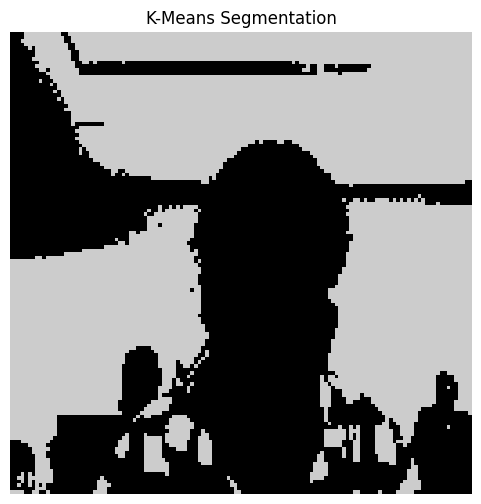

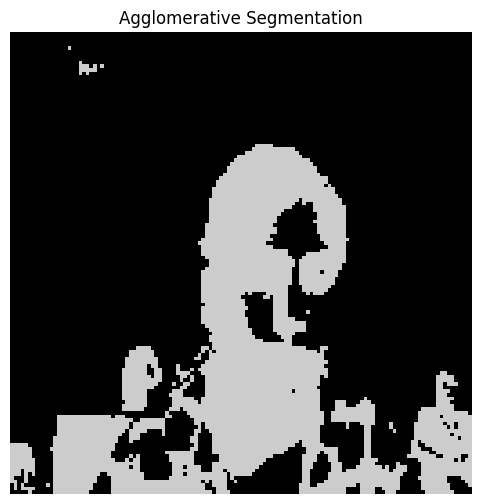

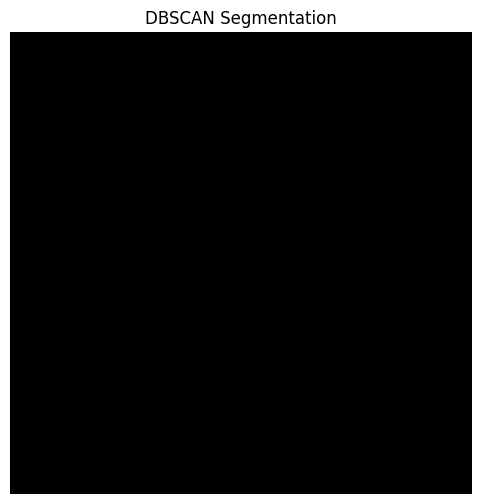

In [19]:
import matplotlib.pyplot as plt

def show_segmented(segmented, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(segmented, cmap='nipy_spectral')
    plt.title(title)
    plt.axis('off')
    plt.show()

show_segmented(seg_kmeans, "K-Means Segmentation")
show_segmented(seg_agglo, "Agglomerative Segmentation")
show_segmented(seg_dbscan, "DBSCAN Segmentation")

In [20]:
import numpy as np
from sklearn.cluster import KMeans
target_cluster = 0
masked_pixels = np.where((labels_kmeans.reshape(-1) == target_cluster)[:, None],
                         [255, 255, 255],  # white
                         pixel_data)

masked_image = masked_pixels.reshape(image.shape)

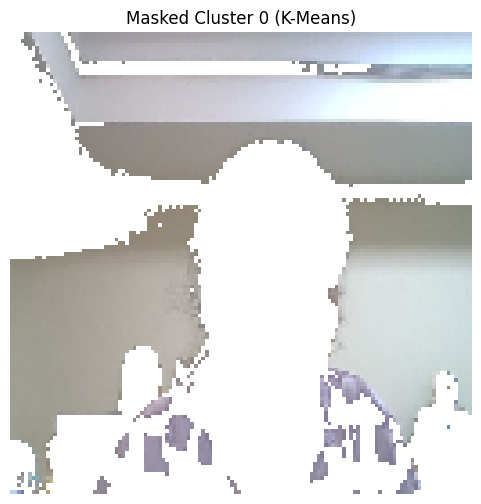

In [21]:
plt.figure(figsize=(6, 6))
plt.imshow(masked_image.astype(np.uint8))
plt.title(f"Masked Cluster {target_cluster} (K-Means)")
plt.axis('off')
plt.show()

In [22]:
from scipy.spatial.distance import pdist, squareform

def custom_agglomerative(data, num_clusters):
    from collections import defaultdict

    # Initial clusters: each point is its own cluster
    clusters = {i: [i] for i in range(len(data))}
    distances = squareform(pdist(data))

    while len(clusters) > num_clusters:
        # Find closest pair of clusters
        min_dist = float('inf')
        pair = None
        keys = list(clusters.keys())
        for i in range(len(keys)):
            for j in range(i+1, len(keys)):
                ci, cj = keys[i], keys[j]
                dists = [distances[p1][p2] for p1 in clusters[ci] for p2 in clusters[cj]]
                dist = min(dists)  # single linkage
                if dist < min_dist:
                    min_dist = dist
                    pair = (ci, cj)

        # Merge clusters
        ci, cj = pair
        clusters[ci].extend(clusters[cj])
        del clusters[cj]

    # Assign labels
    labels = np.zeros(len(data), dtype=int)
    for label, indices in enumerate(clusters.values()):
        for idx in indices:
            labels[idx] = label
    return labels

In [23]:
def custom_dbscan(data, eps, min_samples):
    from sklearn.metrics.pairwise import euclidean_distances

    distances = euclidean_distances(data)
    visited = np.zeros(len(data), dtype=bool)
    labels = np.full(len(data), -1)
    cluster_id = 0

    def region_query(point_idx):
        return np.where(distances[point_idx] < eps)[0]

    for i in range(len(data)):
        if visited[i]:
            continue
        visited[i] = True
        neighbors = region_query(i)
        if len(neighbors) < min_samples:
            labels[i] = -1  # noise
        else:
            labels[i] = cluster_id
            seeds = list(neighbors)
            while seeds:
                j = seeds.pop()
                if not visited[j]:
                    visited[j] = True
                    new_neighbors = region_query(j)
                    if len(new_neighbors) >= min_samples:
                        seeds.extend(new_neighbors)
                if labels[j] == -1:
                    labels[j] = cluster_id
            cluster_id += 1
    return labels

In [ ]:
labels_custom_agglo = custom_agglomerative(pixel_data, num_clusters=2)
labels_custom_dbscan = custom_dbscan(pixel_scaled, eps=0.6, min_samples=50)

# Reshape and visualize
seg_custom_agglo = labels_custom_agglo.reshape(image.shape[:2])
seg_custom_dbscan = labels_custom_dbscan.reshape(image.shape[:2])

show_segmented(seg_custom_agglo, "Custom Agglomerative Segmentation")
show_segmented(seg_custom_dbscan, "Custom DBSCAN Segmentation")